In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import string
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
from nltk.corpus import stopwords 
from collections import Counter
import string
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

sns.set_style('darkgrid')

#https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
#https://nlp.stanford.edu/data/glove.6B.zip

In [2]:
vocab_size = 1000
seq_len = 500
batch_size = 50

In [3]:
base_csv = 'data/imdb.csv'
df = pd.read_csv(base_csv)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (37500,)
shape of test data is (12500,)


In [5]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:vocab_size]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

C:\Users\GOKULA~1\AppData\Local\Temp/ipykernel_15624/2507862157.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


In [6]:
def padding_(sentences, seq_len):
    padded_sentences = []

    for sentence in sentences:
        sentence = np.array(sentence)
        size = sentence.shape[0]
        sentence = sentence.reshape((size,))
        if size >seq_len:
            padded_sentences.append(sentence[:seq_len])
        else:
            padding = np.zeros((seq_len-sentence.shape[0]))
            padded_sentences.append(np.append(padding,sentence))
            
    return np.array(padded_sentences).reshape((len(sentences),seq_len))

x_train_pad = padding_(x_train,seq_len)
x_test_pad = padding_(x_test,seq_len)
y_train = np.array(y_train).reshape((x_train_pad.shape[0],1))
y_test = np.array(y_test).reshape((x_test_pad.shape[0],1))

In [7]:
print(x_train_pad.shape,x_test_pad.shape,y_train.shape)

(37500, 500) (12500, 500) (37500, 1)


In [8]:
class imdb_dataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y
        self.len = len(x)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self,idx):
        return self.x[idx] , self.y[idx]
    
train_dataset = imdb_dataset(torch.LongTensor(x_train_pad),torch.FloatTensor(y_train))
train_dataloader = DataLoader(train_dataset,batch_size = batch_size,shuffle = True)

test_dataset = imdb_dataset(torch.LongTensor(x_train_pad),torch.FloatTensor(y_train))
test_dataloader = DataLoader(test_dataset,batch_size = batch_size,shuffle = True)

In [9]:
torch.cuda.empty_cache()

class lstm_model(nn.Module):
    def __init__(self,device,hidden_size,n_layer,vocab_size,embedding_size):
        super().__init__()
        if 'embs_npa.npy' in os.listdir('data/'):
            embs_npa = np.load('data/embs_npa.npy')
        else:
            vocab,embeddings = [],[]
            with open('data/glove.6B.50d.txt','rb') as fi:
                full_content = fi.read().decode().strip().split('\n')
            for i in range(len(full_content)):
                i_word = full_content[i].split(' ')[0]
                i_embeddings = [float(val) for val in full_content[i].split(' ')[1:]]
                vocab.append(i_word)
                embeddings.append(i_embeddings)

            vocab_npa = np.array(vocab)
            embs_npa = np.array(embeddings)

            vocab_npa = np.insert(vocab_npa, 0, '<pad>')
            vocab_npa = np.insert(vocab_npa, 1, '<unk>')

            pad_emb_npa = np.zeros((1,embs_npa.shape[1]))   #embedding for '<pad>' token.
            unk_emb_npa = np.mean(embs_npa,axis=0,keepdims=True)    #embedding for '<unk>' token.

            #insert embeddings for pad and unk tokens at top of embs_npa.
            embs_npa = np.vstack((pad_emb_npa,unk_emb_npa,embs_npa))
            np.save('data/embs_npa.npy',embs_npa)
        
        self.device = device
        self.n_layer = n_layer
        self.hidden_size = hidden_size
#         self.embedding_layer = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.embedding_layer = nn.Embedding.from_pretrained(torch.from_numpy(embs_npa).float(),freeze=False)
        self.dropout = nn.Dropout(0.2)
        self.lstm_layer = nn.LSTM(embedding_size,hidden_size,n_layer,batch_first = True)
        self.l1 = nn.Linear(hidden_size,50)
        self.bn = nn.BatchNorm1d(50)
        self.l2 = nn.Linear(50,1)
        self.out = nn.Linear(hidden_size,1)

    def forward(self,x):
        hidden = (torch.zeros((self.n_layer,batch_size,self.hidden_size)).to(self.device),torch.zeros((self.n_layer,batch_size,self.hidden_size)).to(self.device))
        x = self.embedding_layer(x)
        x = self.dropout(x)
        out , (h,c) = self.lstm_layer(x)
        x = F.relu(self.l1(h[-1]))
        x = self.bn(x)
        x = torch.sigmoid(self.l2(x))

        return x
    
    
lr = 0.001
epoch = 20

train_n_minibatches = train_dataloader.__len__()
validation_n_minibatches = test_dataloader.__len__()

device = 'cuda'
model = lstm_model(device,hidden_size = 256,n_layer= 2,vocab_size = len(vocab)+1,embedding_size = 50).to(device)

loss_history = [[],[]]
accuracy_history = [[],[]]

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = lr)

In [10]:
def accuracy(pred,target):
    acc = 0
    for i , j in zip(pred,target):
        if round(i[0]) == int(j[0]):
            acc = acc + 1
            
    return acc/len(pred)

log_idx = int(epoch/epoch)

for e in range(epoch):
    for batch_idx , (x ,y) in enumerate(train_dataloader):
        model.train() # Setting mode to train
        optimizer.zero_grad()
        x , y = x.to(device) , y.to(device)
        y_pred  = model(x)
        # Calculating Loss
        loss = criterion(y_pred,y)
        loss_history[0].append(float(loss.detach()))
        loss.backward()
        
        nn.utils.clip_grad_norm_(model.parameters(), epoch)
        optimizer.step()
        
        #Calaculating Accuracy
        y_pred = y_pred.cpu().detach().numpy().tolist()
        y = y.cpu().detach().numpy().tolist()
        accuracy_history[0].append(accuracy(y_pred,y)*100)

    print(f'---------------------------------------EPOCH {e+1}-------------------------------------------')
    print(f'TRAIN LOSS : {sum(loss_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}',end = ' ')
    print(f'TRAIN ACCURACY : {sum(accuracy_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}')
    
    with torch.no_grad():
        for batch_idx , (x ,y) in enumerate(test_dataloader):
            model.eval()
            x , y = x.to(device) , y.to(device)
            y_pred  = model(x)
            # Calculating Loss
            loss = criterion(y_pred,y)
            loss_history[1].append(float(loss.detach()))
            
            #Calaculating Accuracy
            y_pred = y_pred.cpu().detach().numpy().tolist()
            y = y.cpu().detach().numpy().tolist()
            accuracy_history[1].append(accuracy(y_pred,y)*100)           
        
    # Saving the model progress
    torch.save(model.state_dict(),'saved_model/lstm')
    
    #Log for e+1th epoch
    

    print(f'VALIDATION LOSS : {sum(loss_history[1][-1:-1*validation_n_minibatches-1:-1])/validation_n_minibatches}',end = ' ')
    print(f'VALIDATION ACCURACY : {sum(accuracy_history[1][-1:-1*validation_n_minibatches-1:-1])/validation_n_minibatches}')
    print('---------------------------------------------------------------------------------------------')

---------------------------------------EPOCH 1-------------------------------------------
TRAIN LOSS : 0.4990185292760531 TRAIN ACCURACY : 74.08533333333334
VALIDATION LOSS : 1.5175788623491924 VALIDATION ACCURACY : 52.944
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 2-------------------------------------------
TRAIN LOSS : 0.3623717335263888 TRAIN ACCURACY : 84.096
VALIDATION LOSS : 0.4090005403359731 VALIDATION ACCURACY : 80.49866666666667
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 3-------------------------------------------
TRAIN LOSS : 0.34409247585137687 TRAIN ACCURACY : 84.992
VALIDATION LOSS : 0.30176229286193845 VALIDATION ACCURACY : 87.29333333333334
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 4-

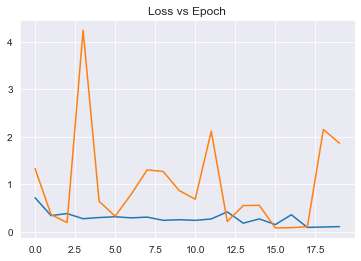

In [11]:
plt.title('Loss vs Epoch')
plt.plot(loss_history[0][::train_n_minibatches])
plt.plot(loss_history[1][::validation_n_minibatches])
plt.show()

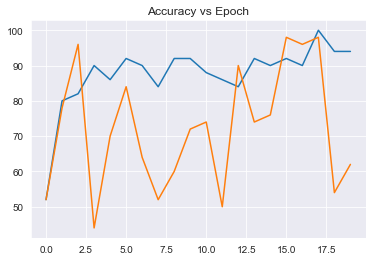

In [12]:
plt.title('Accuracy vs Epoch')
plt.plot(accuracy_history[0][::train_n_minibatches])
plt.plot(accuracy_history[1][::validation_n_minibatches])
plt.show()